In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import random
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import time


%matplotlib inline

In [ ]:
cars = []
noncars = []

cars_files = glob.glob('vehicles/*/*.png')
noncars_files = glob.glob('non-vehicles/*/*.png')

for file in cars_files:
    cars.append(mpimg.imread(file))
for file in noncars_files:
    noncars.append(mpimg.imread(file))
    
cars = np.array(cars)
noncars = np.array(noncars)

# plot a few random car images
fig = plt.figure(figsize = (12, 4))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
indices = random.sample(range(len(cars)), 5)
for i in range(5):
    axis = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    axis.imshow(cars[indices[i]])
plt.show()

# plot a few random noncar images
fig = plt.figure(figsize = (12, 4))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
indices = random.sample(range(len(noncars)), 5)
for i in range(5):
    axis = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    axis.imshow(noncars[indices[i]])
plt.show()


print("cars: ", cars.shape)
print("noncars: ", noncars.shape)

In [ ]:
# experiment here to find the best color scheme, orientations, pixels etc

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


# Reduce the sample size because HOG features are slow to compute
sample_size = 1000
cars = cars[0:sample_size]
noncars = noncars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 8
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
noncar_features = extract_features(noncars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

print(cars.shape)
print(noncars.shape)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))


for i in range(5):
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [ ]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(
            img,
            orientations=orient,
            pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block),
            visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features, hog_image = hog(
            img, 
            orientations=orient, 
            pixels_per_cell=(pix_per_cell, pix_per_cell), 
            cells_per_block=(cell_per_block, cell_per_block), 
            visualise=False,
            feature_vector=feature_vec)

        features = [] # Remove this line
        return features
    
def visualize(fig, rows, cols, images, titles):
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
        else:
            plt.imshow(img)
        plt.title(titles[i])
 

# get a random car image
ind = np.random.randint(0, len(cars))
image = cars[ind]
image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

c1 = image[:,:,0]
c2 = image[:,:,1]
c3 = image[:,:,2]

# Define HOG parameters
orient = 9
pix_per_cell = 2
cell_per_block = 2


# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(c1, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure(figsize=(8,8))
plt.subplot(231)
plt.imshow(c1, cmap='gray')
plt.title('Example H-channel')
plt.subplot(234)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

features, hog_image = get_hog_features(c2, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


plt.subplot(232)
plt.imshow(c2, cmap='gray')
plt.title('Example S-channel')
plt.subplot(235)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

features, hog_image = get_hog_features(c3, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)



       

plt.subplot(233)
plt.imshow(c3, cmap='gray')
plt.title('Example V-channel')
plt.subplot(236)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

plt.show()





In [ ]:
from features import Extractor

features = Extractor(cars[0])
print(features.features().shape)

In [ ]:
# create features vectors
car_features = []
for car in cars:
    features = Extractor(car).features()
    car_features.append(features)
    
noncar_features = []
for noncar in noncars:
    features = Extractor(noncar).features()
    noncar_features.append(features)
    
car_features = np.array(car_features)
noncar_features = np.array(noncar_features)

X = np.vstack([car_features, noncar_features])
y = np.concatenate([np.ones(len(car_features)), np.zeros(len(noncar_features))])

print('cars: ', car_features.shape[0])
print('noncars: ', noncar_features.shape[0])
print(X.shape)
print(y.shape)

In [ ]:
# first scale 
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# split into train and validaton 
# X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)
X_train = scaled_X
y_train = y

X_test = scaled_X
y_test = y

# train
svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy = round(svc.score(X_test, y_test), 4)
print('Accuracy =', accuracy)



In [ ]:
# save scaler and svc
from sklearn.externals import joblib

model = {
    'orient': 9,
    'pixels': 8,
    'cells': 2,
    'size': 32,
    'bins': 32,
    'scaler': X_scaler,
    'svc': svc
}

joblib.dump(model, 'model.pkl') 


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

def visualize_windows(frame):
        scales = [1.25, 1.5, 2.0, 2.5]
        ystarts = [400, 410, 425, 435]
        colors = [(0,0,255), (0,255,0), (255,0,0), (255,255,0)]
        cars = []
        total = 0
        for ystart, scale, color in zip(ystarts, scales, colors):
            ystop = ystart + scale * 80
            img = frame[ystart:ystop,:,:]
            scale_cars, windows = visualize_windows_scale(img, scale, ystart)
            cars.extend(scale_cars)
            total += windows
            for box in scale_cars:
                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), color, 3)
        print("windows: ", total)

def visualize_windows_scale(frame, scale, ystart):
    frame = frame.astype(np.float32) / 255
    img = np.copy(frame)
    (h, w, d) = frame.shape
    frame = cv2.resize(frame, (int(w / scale), int(h / scale)))
    (h, w, d) = frame.shape
    pix_per_cell = 8

    # Define blocks and steps as above
    nxblocks = (w // pix_per_cell)-1
    nyblocks = (h // pix_per_cell)-1
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    cars = []
    windows = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            windows += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            box = [xbox_left, ytop_draw+ystart, xbox_left+win_draw, ytop_draw + win_draw + ystart]
            cars.append(box)
    return cars, windows


frame = mpimg.imread('test_images/test4.jpg')
visualize_windows(frame)
plt.imshow(frame)
plt.show()


In [ ]:
from tracker import Tracker
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

tracker = Tracker()
images = glob.glob('test_images/*.jpg')
for image in images:
    img = mpimg.imread(image)
    img = tracker.find_and_draw_detections(img)
    plt.imshow(img)
    plt.show()

In [ ]:
import cv2
from features import Extractor
import numpy as np

import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

images = glob.glob('test_images/*.jpg')

img = images[0]
frame = cv2.imread(img)

scale = 2.5
pixels = 8

(h, w, d) = frame.shape
frame = cv2.resize(frame, (int(w / scale), int(h / scale)))
(h, w, d) = frame.shape

e1 = Extractor(frame[0:64,0:72,:])

window = 64
nxsteps = ((w - window) // pixels) - 1
nysteps = ((h - window) // pixels) - 1

xb = 0
yb = 0

x = xb * pixels
y = yb * pixels

subimage = frame[y:y+window,x:x+window]
e2 = Extractor(subimage)

print('extracting big window...')
h1 = e1.hog(x, y, window)
print('extracting small window...')
h2 = e2.hog(0, 0, window)

print('big image', h1)
print('small image', h2)
diff = np.nonzero(h1 != h2)[0]
print(len(diff))
print(len(h1))

h1 = e1.hog_features[0:7,0:7,:,:,:]
h2 = e2.hog_features[0:7,0:7,:,:,:]
diff = np.nonzero(h1 != h2)
print(len(diff))
print(diff[0][0],diff[1][0], diff[2][0], diff[3][0], diff[4][0])
print(h1[0, 6,0,0,0], h2[0, 6, 0,0,0])




[MoviePy] >>>> Building video test_video_annotated.mp4
[MoviePy] Writing video test_video_annotated.mp4


 59%|█████▉    | 23/39 [00:10<00:08,  1.88it/s]

maxes 9.0 255
maxes 8.0 255
maxes 8.0 255
maxes 9.0 255
maxes 9.0 255
maxes 9.0 255
maxes 7.0 255
maxes 7.0 255
maxes 7.0 255
maxes 7.0 255
maxes 7.0 255
maxes 7.0 255
maxes 6.0 255
maxes 6.0 255
maxes 7.0 255
maxes 7.0 255
maxes 7.0 255
maxes 8.0 255
maxes 8.0 255
maxes 7.0 255


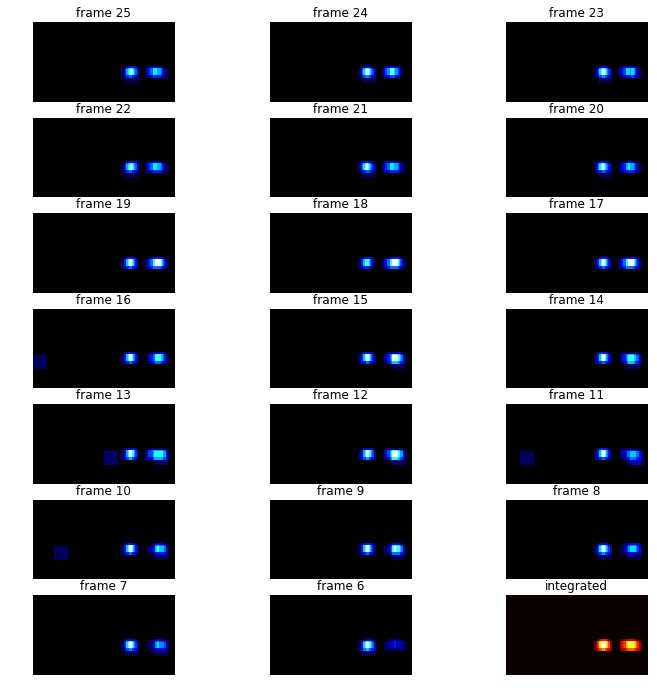

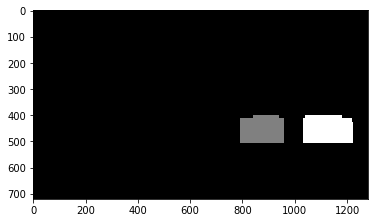

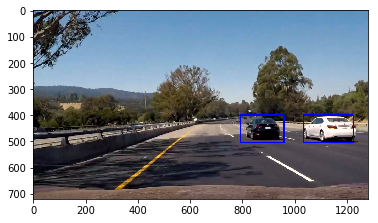

 97%|█████████▋| 38/39 [00:19<00:00,  2.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_annotated.mp4 

[MoviePy] >>>> Building video test_video_annotated.mp4
[MoviePy] Writing video test_video_annotated.mp4


 97%|█████████▋| 38/39 [00:19<00:00,  2.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_annotated.mp4 



In [3]:
from moviepy.editor import VideoFileClip
from tracker import Tracker

frame_count = 0
video_name = "test_video"
video_output_name = video_name + '_annotated.mp4'
video = VideoFileClip(video_name + ".mp4")
tracker = Tracker()
video_output = video.fl_image(tracker.process)
video_output.write_videofile(video_output_name, audio=False)
